## Multi-Step-Horizon 1-day basic dataset


## Loading all the libraries

In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from collections import Counter
import json
import joblib

## Preprocessing And Feature Engineering Dataset For XGBoost

In [2]:
#loading pickle file
df = pd.read_pickle('Hourly_Elec_Original_Data.pkl')


#Ensuring that datetime_hour is a datetime index when we load in the data
df['datetime_hour'] = pd.to_datetime(df['datetime_hour'])
df = df.set_index('datetime_hour')

#Converting the two categorical columns to use in XGBoost
categorical = ['insee_region', 'weather_code']
for col in categorical:
    df[col] = df[col].astype('category')


#Now we sort by region and datetime so we can add the lags
df = df.sort_values(['insee_region', 'datetime_hour'])


#Here we will create the lag features
lags = [1,2,3,23,24,25, 32, 48,72,168]
for lag in lags:
    df[f"lag_{lag}h"] = (df.groupby('insee_region')['conso_elec_mw'].shift(lag).transform(lambda x: x.fillna(method = 'bfill', limit = lag)))

#Creating rolling windows  for the rolling features
rolling_windows = [6,12,24,48,72, 96]

#creating the rolling window mean and std features 
for window in rolling_windows:
    df[f"roll_mean{window}h"] = df.groupby('insee_region')['conso_elec_mw'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f"roll_std{window}h"] = df.groupby('insee_region')['conso_elec_mw'].transform(lambda x: x.rolling(window, min_periods=1).std())
    df[f"roll_std{window}h"] = df[f"roll_std{window}h"].fillna(df[f"roll_std{window}h"].mean())


#We will set the target variables We need 24 targets,  and use shift of -h(24) because we will predict 24 hours ahead.
horizon = 24
for h in range(1, horizon+1):
    df[f"target_{h}h"] = df.groupby('insee_region', observed = True)['conso_elec_mw'].shift(-h)

target_cols = [f"target_{h}h" for h in range(1,25)]

#Then we will dropp all the rows that are NaN with the target variables.
df = df.dropna(subset= target_cols).reset_index(drop = True)

## Setting Up Data

In [12]:
#We make the masks so we can use this to split the data on
mask_train = df['year'].isin([2015,2016,2017])
mask_val = df['year'] == 2018
mask_test = df['year'] == 2019


#Here we set the target feature and the features we use to train the model
X = df.drop(columns = target_cols)
y = df[target_cols]


#here we splitt the data up official
X_train, y_train = X[mask_train], y[mask_train]
X_val, y_val = X[mask_val], y[mask_val]
X_test, y_test = X[mask_test], y[mask_test]

## SETTING UP MODEL AND HYPERPARAMETERTUNING

In [4]:
#Here we first define optuna with the parameter ranges to use for hyperparametertuning
def optuna_tuning(tuning):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'n_estimators': tuning.suggest_int('n_estimators', 100, 1000),
        'max_depth': tuning.suggest_int('max_depth', 3,12),
        'learning_rate': tuning.suggest_float('learning_rate', 0.001, 0.3, log = True),
        'subsample': tuning.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': tuning.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': tuning.suggest_float('gamma', 0, 5),
        'reg_alpha': tuning.suggest_float('reg_alpha', 0.00000001, 1.0, log = True),
        'reg_lambda': tuning.suggest_float('reg_lambda', 0.00000001, 1.0, log = True),
        'random_state': 42,
        'enable_categorical': True,
    }
    
    #here we define the model that we will be using
    base_model = xgb.XGBRegressor(**params)
    multi_model = MultiOutputRegressor(base_model)
    multi_model.fit(
        X_train,
        y_train,
        verbose=False
    )
    
    y_val_pred  = multi_model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    
    tuning.report(mae_val, step = 0)
    if tuning.should_prune():
        raise optuna.TrialPruned()
    print(f'tune {tuning.number}: MAE = {mae_val:.4f}')
    return mae_val
    
#Here we run the optuna study
tune = optuna.create_study(direction = 'minimize')
tune.optimize(optuna_tuning, n_trials = 15, show_progress_bar = True)
best_parameters = tune.best_params

print('\n')
print('Best parameters:', tune.best_params)
print('Best MAE:', tune.best_value)

## Save the hyperparameter tuning

In [12]:
with open('best_xgb_params_24H_Original_Data_forecasting.json', 'w') as f:
    json.dump(tune.best_params, f)

## Open the HyperParameter Tuning 

In [15]:
with open('best_xgb_params_24H_Original_Data_forecasting.json', 'r') as f:
    loaded_params = json.load(f)
    best_parameters = loaded_params

## Retrain the model with the best hyperparamters

In [6]:
#We select the XGBregressor because we are doing regression and not classification
base_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 42,
    enable_categorical = True,
    **best_parameters
)

tuned_model = MultiOutputRegressor(base_model)

#Fitting on the full training set before predicting with the right hyperparapeter values
tuned_model.fit(X_train, y_train, verbose = False)

## Feature Importance

### Creating subset for feature importance

In [18]:
# setting the parapemeters for the subset data
#here we set to use seven days of hourly data
week_hours = 24 * 7  # 7 days of hourly data
months_in_year = X_test['month'].unique()  
X_test_sub = pd.DataFrame()
y_test_sub = pd.DataFrame()

# dataset contains 12 regions, so we need to loop over all regions
for reg in X_test['insee_region'].unique():
    reg_mask = X_test['insee_region'] == reg
    reg_data = X_test.loc[reg_mask]
    reg_target = y_test.loc[reg_mask]

    #we will loop over all months because we take a week of each month
    for month in months_in_year:
        month_mask = reg_data['month'] == month
        month_idx = reg_data[month_mask].index
        if len(month_idx) >= week_hours:
            selected_idx = month_idx[:week_hours]
        else:
            selected_idx = month_idx

        X_test_sub = pd.concat([X_test_sub, reg_data.loc[selected_idx]])
        y_test_sub = pd.concat([y_test_sub, reg_target.loc[selected_idx]])

# to prevent errors, we need to reset the index
X_test_sub = X_test_sub.reset_index(drop=True)
y_test_sub = y_test_sub.reset_index(drop=True)

print("X_test_sub shape:", X_test_sub.shape)
print("y_test_sub shape:", y_test_sub.shape)


X_test_sub shape: (24192, 50)
y_test_sub shape: (24192, 24)


### Permutation feature importance

Top Features by Permutation Importance (%):
roll_mean: 49.16%
lags: 12.99%
conso_elec_mw: 11.12%
insee_region: 7.74%
hour: 7.21%
day_of_week: 4.98%
conso_gaz_mw: 1.77%
roll_std: 1.64%
temperature_2m: 1.01%
week_of_year: 0.72%
diffuse_radiation: 0.54%
month: 0.23%
wind_direction_10m: 0.19%
shortwave_radiation: 0.19%
pressure_msl: 0.10%


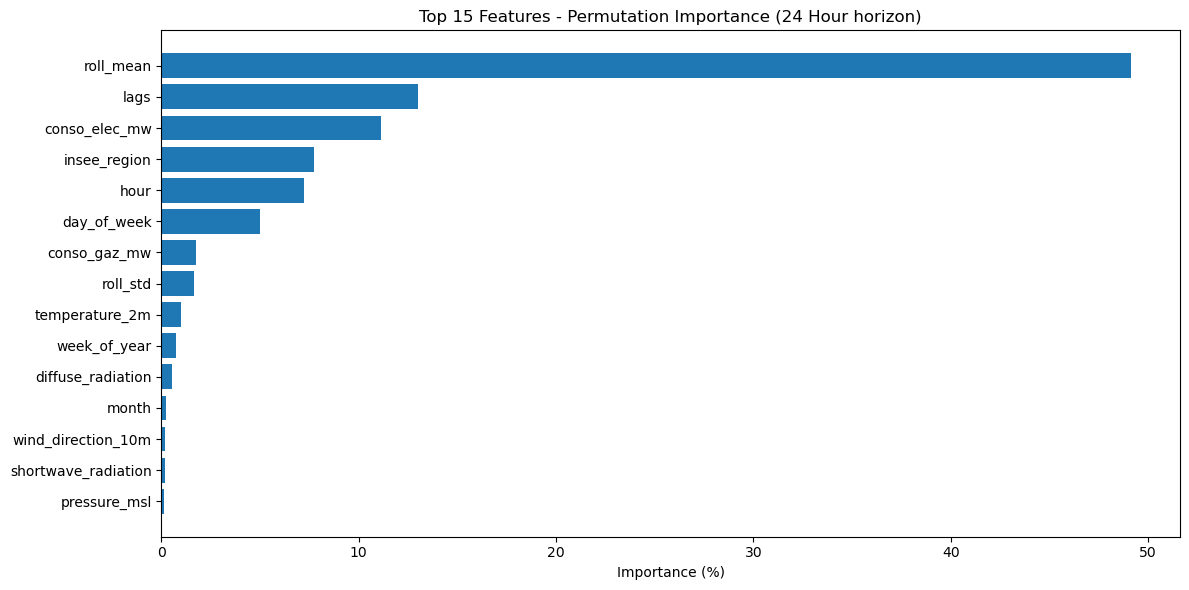

In [15]:
#Setting the parapeters of the permutation importance
n_repeats = 1 #shuflling only once
top_n = 15  #selecting only the top 15 features
rng = np.random.default_rng(42)

# getting the baseline MAE on the test subset
baseline_pred = tuned_model.predict(X_test_sub)
baseline_score = mean_absolute_error(y_test_sub, baseline_pred)

# Computing the permutation importance 
importances = np.zeros(X_test_sub.shape[1])
X_test_permute = X_test_sub.copy()

for i, col in enumerate(X_test_sub.columns):
    scores = []
    original_col = X_test_permute[col].copy()
    for _ in range(n_repeats):
        X_test_permute[col] = rng.permutation(original_col)
        y_pred_perm = tuned_model.predict(X_test_permute)
        scores.append(mean_absolute_error(y_test_sub, y_pred_perm))
    X_test_permute[col] = original_col
    importances[i] = np.mean(scores) - baseline_score



# Converting the raw values into the percentages
importances_pct = 100 * importances / np.sum(importances)

# Creating the features based on the one-hot encoded features, to get a better overview
one_hot_groups = {
    'region': [c for c in X_test_sub.columns if 'insee_region_' in c],
    'weather': [c for c in X_test_sub.columns if 'weather_code_' in c],
    'school_zone': [c for c in X_test_sub.columns if 'school_zone_' in c],
    'vacation_name': [c for c in X_test_sub.columns if 'vacation_name_' in c],
    'holiday_name': [c for c in X_test_sub.columns if 'holiday_name_' in c],
    'season': [c for c in X_test_sub.columns if 'season_' in c],
    'lags': [c for c in X_test_sub.columns if 'lag_' in c],
    'roll_mean': [c for c in X_test_sub.columns if 'roll_mean' in c],
    'roll_std': [c for c in X_test_sub.columns if 'roll_std' in c],
}

#Preparing arros for the grouped importances 
importances_clean = importances_pct.copy()
feature_names_clean = X_test_sub.columns.to_list()
used_features = set(sum(one_hot_groups.values(), []))

#aggregating the grouped features into their groups
for group_name, cols in one_hot_groups.items():
    mask = [i for i, f in enumerate(feature_names_clean) if f in cols]
    if mask:
        if group_name in ['region','weather','school_zone','vacation_name','holiday_name','season']:
            group_val = importances_clean[mask].mean()
        else:
            group_val = importances_clean[mask].sum()
        importances_clean = np.delete(importances_clean, mask)
        feature_names_clean = [f for i, f in enumerate(feature_names_clean) if i not in mask]
        importances_clean = np.append(importances_clean, group_val)
        feature_names_clean.append(group_name)

# Selecting the top features by importance
top_idx = np.argsort(importances_clean)[-top_n:][::-1]

print("Top Features by Permutation Importance (%):")
for i in top_idx:
    print(f"{feature_names_clean[i]}: {importances_clean[i]:.2f}%")

# Creating the plot
plt.figure(figsize=(12,6))
plt.barh([feature_names_clean[i] for i in top_idx], [importances_clean[i] for i in top_idx])
plt.xlabel("Importance (%)")
plt.title(f"Top {top_n} Features - Permutation Importance (24 Hour horizon)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('permutation_feature_importance_24h_Without_Exogenous.png', dpi=300, bbox_inches='tight')
plt.show()

### XGBoost Native Feature Importance (GAIN)


Top 15 Grouped XGBoost Native Feature Importances (by Gain):

            feature         gain  gain_pct
          roll_mean 5.224847e+09 78.802108
               lags 9.979401e+08 15.051118
      conso_elec_mw 1.644383e+08  2.480088
        day_of_week 4.542453e+07  0.685101
         is_weekend 3.969977e+07  0.598759
               hour 3.924704e+07  0.591931
  diffuse_radiation 3.161503e+07  0.476824
           roll_std 2.774192e+07  0.418409
shortwave_radiation 9.365154e+06  0.141247
       conso_gaz_mw 6.732363e+06  0.101539
       insee_region 5.786397e+06  0.087272
     temperature_2m 4.393490e+06  0.066263
       week_of_year 3.932884e+06  0.059316
              month 3.741714e+06  0.056433
            quarter 3.212010e+06  0.048444


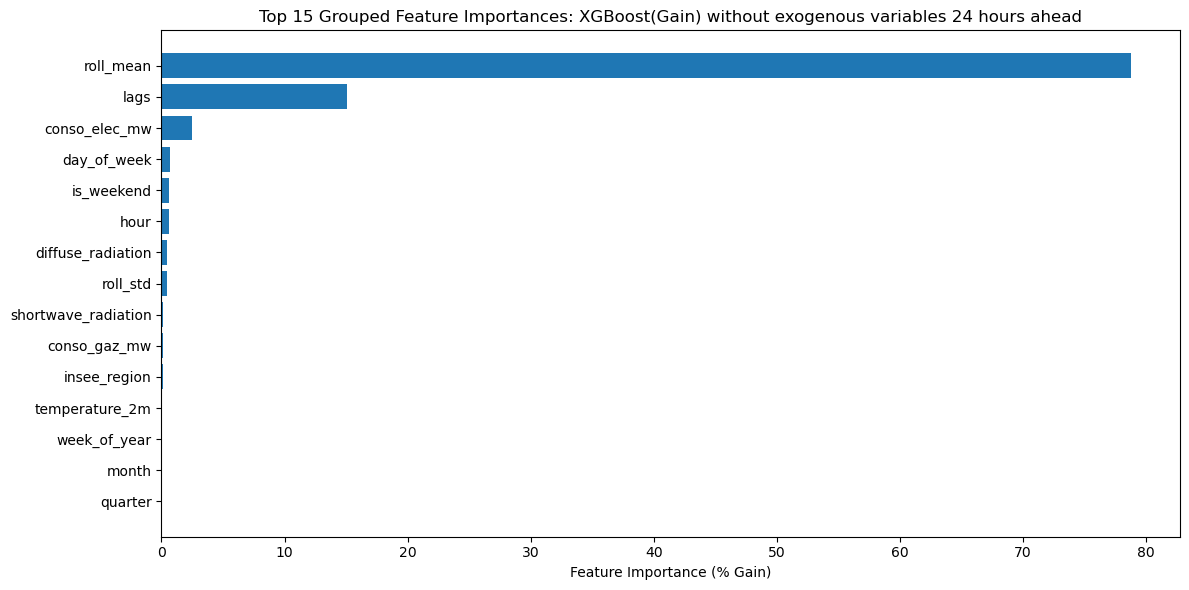

In [19]:
#collection for each model is needed because xgb trains each horizon on a seperate model
estimators = tuned_model.estimators_
group_importances_list = []

# Get feature importance values from XGBoost native model using the gain metric
for est in estimators:
    fi_xgb = est.get_booster().get_score(importance_type='gain')
    # Converting the importance into a DataFRam
    fi_xgb_df = pd.DataFrame({
        'feature': list(fi_xgb.keys()),
        'gain': list(fi_xgb.values())
    })

    # Creating the features based on the one-hot encoded features, to get a better overview
    one_hot_groups = {
        'region': [c for c in X_train.columns if 'insee_region_' in c],
        'weather': [c for c in X_train.columns if 'weather_code_' in c],
        'school_zone': [c for c in X_train.columns if 'school_zone_' in c],
        'vacation_name': [c for c in X_train.columns if 'vacation_name_' in c],
        'holiday_name': [c for c in X_train.columns if 'holiday_name_' in c],
        'season': [c for c in X_train.columns if 'season_' in c],
        'lags': [c for c in X_train.columns if 'lag_' in c],
        'roll_mean': [c for c in X_train.columns if 'roll_mean' in c],
        'roll_std': [c for c in X_train.columns if 'roll_std' in c],
    }

    # aggregating the grouped importance values
    group_importances = {}
    used_features = set(sum(one_hot_groups.values(), []))

    for group_name, cols in one_hot_groups.items():
        subset = fi_xgb_df.loc[fi_xgb_df['feature'].isin(cols), 'gain']
        if subset.empty:
            continue
         # Averaging the importance of the one-hot encoded groups
        if group_name in ['region','weather','school_zone','vacation_name','holiday_name','season']:
            group_importances[group_name] = subset.mean()
        else:
            group_importances[group_name] = subset.sum()

    for f in fi_xgb_df['feature']:
        if f not in used_features:
            group_importances[f] = fi_xgb_df.loc[fi_xgb_df['feature'] == f, 'gain'].values[0]

    group_importances_list.append(group_importances)

#Averaging the features over all horizons inside the horizon because of the model use of XGBoost
all_features = set().union(*[d.keys() for d in group_importances_list])
avg_importances = {}
for f in all_features:
    avg_importances[f] = np.mean([d.get(f, 0) for d in group_importances_list])

# creating a table with the importance to see the perccentage easier
fi_grouped = pd.DataFrame(list(avg_importances.items()), columns=['feature','gain'])
fi_grouped['gain_pct'] = 100 * fi_grouped['gain'] / fi_grouped['gain'].sum()
fi_grouped = fi_grouped.sort_values(by='gain_pct', ascending=False).head(15)
print("Top 15 Grouped XGBoost Native Feature Importances (by Gain):")
print(fi_grouped.to_string(index=False))

#Creating the plot
plt.figure(figsize=(12,6))
plt.barh(fi_grouped['feature'], fi_grouped['gain_pct'])
plt.xlabel('Feature Importance (% Gain)')
plt.title('Top 15 Grouped Feature Importances: XGBoost(Gain) without exogenous variables 24 hours ahead')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_grouped_XGB_Gain_24H_without_exogenous.png', dpi=300, bbox_inches='tight')
plt.show()


## Testing the model and Evaluation General

In [24]:
#Now we will be doing the model  actual predictions on the testset
y_test_pred = tuned_model.predict(X_test)

#Evaluation metrics calculation on the test set
rmse_test = mean_squared_error(y_test, y_test_pred)**0.5
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test))*100

print("The results for the test set")
print(f"RMSE:{rmse_test:.2f}")
print(f"MAE:{mae_test:.2f}")
print(f"MAPE:{mape_test:.2f}")

print('Actual vs Predicited values (first 2 rows):')
print(np.vstack([y_test.values[:1], y_test_pred[:8]]).T)


The results for the test set
RMSE:393.23
MAE:247.70
MAPE:2.89
Actual vs Predicited values (first 2 rows):
[[17381.     16642.357  15866.929  15655.764  15090.274  14866.076
  15113.418  15853.587  15701.813 ]
 [16178.     15352.549  15078.304  15066.091  15243.115  15807.011
  17112.281  18183.53   17332.176 ]
 [15623.     14953.018  14848.554  15064.4375 16301.173  18040.494
  19662.184  20385.004  19287.023 ]
 [14834.     14597.4795 14716.599  16104.456  18069.648  20376.56
  20597.18   21312.434  20056.33  ]
 [14524.     14712.299  15676.022  18063.053  20091.93   20751.346
  21236.693  21295.598  20555.012 ]
 [14673.     15737.498  17801.973  20248.535  20891.998  21220.389
  21332.336  21524.1    20220.89  ]
 [14759.     17689.133  19856.99   20661.453  21019.143  21088.65
  21420.703  21380.84   20141.725 ]
 [15048.     20137.96   20769.701  20886.74   21048.473  21228.197
  20864.934  20572.209  19923.213 ]
 [15117.     21206.31   21027.068  21400.984  20874.832  20807.01
  2014

## Evaluation Regional General


In [17]:
#Defining function to create regional performance metrics (RMSE, MAE, MAPE)
def evaluate_regions(X_test, y_test, y_pred, region_col = 'insee_region'):
    #converting prediction into arrays 
    y_true = np.array(y_test)
    y_pred = np.array(y_pred)
    n_horizons = y_true.shape[1]
    
    #repeating for each region and horizon and flatten the target
    regions = np.repeat(X_test[region_col].values, n_horizons)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    df  = pd.DataFrame({
        'region': regions,
        'y_true': y_true_flat,
        'y_pred': y_pred_flat
    })

    #computing the metrics for each specific region
    def region_metrics(group):
        rmse = mean_squared_error(group['y_true'], group['y_pred']) **0.5
        mae = mean_absolute_error(group['y_true'], group['y_pred'])
        mape = np.mean(np.abs((group['y_true'] - group['y_pred']) / group['y_true'])) * 100
        return pd.Series({'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

    return df.groupby('region').apply(region_metrics).reset_index()

#Running the funtion
regional_evaluation = round(evaluate_regions(X_test, y_test, y_test_pred),2)

print("Test Evaluation regional performance")
print(regional_evaluation)

## Evaluation Regional Hourly Specific

In [27]:
#Defining function for region-level metrics for every forecast horizon
def evaluate_specific(X_test, y_test, y_pred, region_col = 'insee_region'):
    results = []
    #converitng all regions inputs to numpy
    regions = X_test[region_col].unique()
    y_test_np = y_test.values if isinstance(y_test, pd.DataFrame) else y_test
    y_pred_np = y_pred.values if isinstance(y_pred, pd.DataFrame) else y_pred

    n_horizons = y_pred_np.shape[1]

     #looping thoruh each region and horizon and storing results in dataframe
    for region in regions:
        mask = X_test[region_col] == region
        mask_np = mask.values
        for horizon in range(n_horizons):
            yt = y_test_np[mask_np, horizon]
            yp = y_pred_np[mask_np, horizon]
            mae = mean_absolute_error(yt, yp)
            rmse = mean_squared_error(yt, yp)**0.5
            mape = np.mean(np.abs((yt - yp) / yt)) * 100

            results.append({
                'region': region,
                'horizon':  horizon +1,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape
            })
    return pd.DataFrame(results)
                
            
            
    

   
#run the defined function
specific_evaluation = round(evaluate_specific(X_test, y_test, y_test_pred),2)
print("Test Evaluation regional performance")
print(specific_evaluation.head(24))

Test Evaluation regional performance
    region  horizon     MAE    RMSE  MAPE
0       11        1  150.21  225.14  0.94
1       11        2  222.19  324.81  1.44
2       11        3  273.64  395.77  1.77
3       11        4  319.44  466.22  2.06
4       11        5  355.65  519.77  2.28
5       11        6  388.75  562.68  2.48
6       11        7  408.16  588.66  2.60
7       11        8  427.89  607.81  2.72
8       11        9  438.47  619.07  2.79
9       11       10  449.30  630.58  2.85
10      11       11  463.84  645.60  2.94
11      11       12  477.78  663.88  3.03
12      11       13  485.85  680.04  3.07
13      11       14  501.65  703.36  3.17
14      11       15  508.65  714.07  3.20
15      11       16  527.04  736.97  3.32
16      11       17  534.01  742.29  3.36
17      11       18  536.89  750.84  3.38
18      11       19  541.74  759.71  3.39
19      11       20  549.84  777.14  3.44
20      11       21  556.49  792.92  3.46
21      11       22  556.79  793.13  3.

In [31]:
#Computing the average metrics per horizon for all regions
flattened = (
    specific_evaluation
    .groupby('horizon')[['MAE', 'RMSE', 'MAPE']]
    .mean()
    .reset_index()
    .round(2)
)

#saving for easier plotting for thesis plots
flattened.to_csv('flattened_xgboost_24h_original.csv', index=False)


## Error code plots for thesis

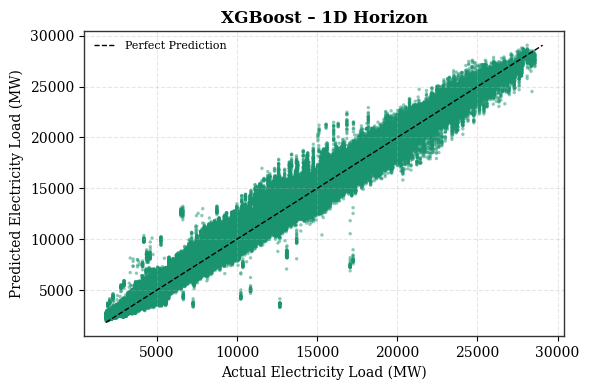

In [31]:
# setting the forecast horizon label for the plot
horizon_name = '1D'

# flatten true and predicted values into array 
y_true_flat = y_test.values.flatten()     
y_pred_flat = y_test_pred.flatten() if isinstance(y_test_pred, np.ndarray) else y_test_pred.values.flatten()

#creating the dataframe for plotting
df = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat
})

#Setting a professional style
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 1

# setting the same color as for the other plots using XGBoost
color_xgb = '#1A936F'

#creating the figure
fig, ax = plt.subplots(figsize=(6, 4))

# creating the scatter plot points
ax.scatter(df['y_true'], df['y_pred'],
           alpha=0.5, s=6, color=color_xgb,
           edgecolor='none', linewidths=0, rasterized=True)

# creating the perfect diagonal line for predictions
min_val = min(df['y_true'].min(), df['y_pred'].min())
max_val = max(df['y_true'].max(), df['y_pred'].max())
ax.plot([min_val, max_val], [min_val, max_val],
        'k--', linewidth=1, label='Perfect Prediction')


# adding labels and titles
ax.set_title(f"XGBoost – {horizon_name} Horizon", fontsize=12, fontweight='bold')
ax.set_xlabel("Actual Electricity Load (MW)", fontsize=10)
ax.set_ylabel("Predicted Electricity Load (MW)", fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(frameon=False, fontsize=8, loc='upper left')

plt.tight_layout()
plt.savefig("XGBoost_1D_Original_Prediction.png", dpi=600, bbox_inches='tight')
plt.show()

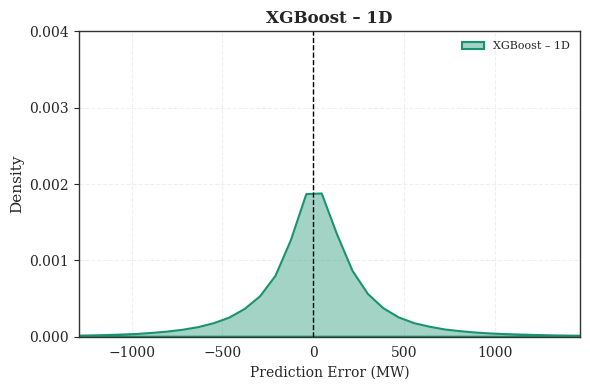

In [34]:
# setting the forecast horizon label for the plot
horizon_name = '1D'  

# flatten true and predicted values into array 
y_true_flat = y_test.values.flatten()
y_pred_flat = y_test_pred.flatten() if isinstance(y_test_pred, np.ndarray) else y_test_pred.values.flatten()

#creating the dataframe for plotting
df = pd.DataFrame({
    'y_true': y_true_flat,
    'y_pred': y_pred_flat
})
df['error'] = df['y_pred'] - df['y_true']

#Setting a professional style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 1

# setting the same color as for the other plots using XGBoost
color_xgb = '#1A936F'

#creating the figure
fig, ax = plt.subplots(figsize=(6, 4))

#drawing the KDE curve 
sns.kdeplot(
    df['error'],
    fill=True, alpha=0.4, color=color_xgb,
    linewidth=1.5, ax=ax, label=f'XGBoost – {horizon_name}'
)

# adding a reference line at the zero error for better visibility
ax.axvline(0, color='k', linestyle='--', linewidth=1)

#zooming for the central part of error distribution
xmin, xmax = np.percentile(df['error'], [1, 99])
margin = (xmax - xmin) * 0.1
ax.set_xlim(xmin - margin, xmax + margin)

# adding labels and titles
ax.set_ylim(0, 0.004)
ax.set_yticks([0.000, 0.001, 0.002, 0.003, 0.004])
ax.set_yticklabels(['0.000', '0.001', '0.002', '0.003', '0.004'])
ax.set_title(f"XGBoost – {horizon_name}", fontsize=12, fontweight='bold')
ax.set_xlabel("Prediction Error (MW)", fontsize=10)
ax.set_ylabel("Density", fontsize=11)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(frameon=False, fontsize=8, loc='upper right')

ax.tick_params(axis='y', which='both', left=True, labelleft=True)

plt.tight_layout()
plt.savefig("XGBoost_Original_Data_1D_ErrorDensity.png", dpi=600, bbox_inches='tight')
plt.show()